In [1]:

# # Summer 2021
# !java -version

# #Install Spark
# #download file
# !wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.1.tgz
# #extract the file
# !tar xf spark-3.1.1-bin-hadoop3.1.tgz
# #install findspark package
# !pip install -q findspark

# import os
# os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.1"

import findspark
findspark.init()


# create entry points to spark
try:
    sc.stop()
except:
    pass

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("Project").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [2]:
# Read in the BTC json file
dfbtc = spark.read.json("btc.json")

For some reason reading in the file creates a null record column, drop that column as it is unnecessary

This happens due to the power going out on our Raspberry Pi and it created an extra line entry, causing a corrupt record.

In [3]:
from pyspark.sql.functions import col

# Drop the corrupt records (safe to do so)
dfbtc = dfbtc.drop(col('_corrupt_record'))

# Show the dataframe
dfbtc.show(truncate=False)

+-------+-----------+-------------------------+
|name   |price      |updated                  |
+-------+-----------+-------------------------+
|Bitcoin|36,240.9517|2021-06-29T17:51:00+00:00|
|Bitcoin|36,227.8517|2021-06-29T18:07:00+00:00|
|Bitcoin|36,226.7417|2021-06-29T18:08:00+00:00|
|Bitcoin|36,204.6300|2021-06-29T18:09:00+00:00|
|Bitcoin|36,227.0517|2021-06-29T18:10:00+00:00|
|Bitcoin|36,258.8150|2021-06-29T18:11:00+00:00|
|Bitcoin|36,275.2100|2021-06-29T18:12:00+00:00|
|Bitcoin|36,284.7933|2021-06-29T18:13:00+00:00|
|Bitcoin|36,286.0933|2021-06-29T18:14:00+00:00|
|Bitcoin|36,285.4517|2021-06-29T18:15:00+00:00|
|Bitcoin|36,222.4367|2021-06-29T18:16:00+00:00|
|Bitcoin|36,255.0500|2021-06-29T18:17:00+00:00|
|Bitcoin|36,213.3417|2021-06-29T18:18:00+00:00|
|Bitcoin|36,237.5567|2021-06-29T18:19:00+00:00|
|Bitcoin|36,242.7567|2021-06-29T18:20:00+00:00|
|Bitcoin|36,215.2483|2021-06-29T18:21:00+00:00|
|Bitcoin|36,200.8067|2021-06-29T18:22:00+00:00|
|Bitcoin|36,206.7567|2021-06-29T18:23:00

In [4]:
from pyspark.sql.functions import when, translate

# Convert the time to a usable timestamp object
dfbtc = dfbtc.withColumn('timestamp', col('updated').cast('timestamp'))

# Convert the price to a usable float object
dfbtc = dfbtc.select('price', 'timestamp', translate(col('price'), ',', '').cast('float').alias('newprice'))

# Show the updated dataframe
dfbtc.show()

+-----------+-------------------+---------+
|      price|          timestamp| newprice|
+-----------+-------------------+---------+
|36,240.9517|2021-06-29 13:51:00|36240.953|
|36,227.8517|2021-06-29 14:07:00| 36227.85|
|36,226.7417|2021-06-29 14:08:00|36226.742|
|36,204.6300|2021-06-29 14:09:00| 36204.63|
|36,227.0517|2021-06-29 14:10:00| 36227.05|
|36,258.8150|2021-06-29 14:11:00|36258.816|
|36,275.2100|2021-06-29 14:12:00| 36275.21|
|36,284.7933|2021-06-29 14:13:00|36284.793|
|36,286.0933|2021-06-29 14:14:00|36286.094|
|36,285.4517|2021-06-29 14:15:00|36285.453|
|36,222.4367|2021-06-29 14:16:00|36222.438|
|36,255.0500|2021-06-29 14:17:00| 36255.05|
|36,213.3417|2021-06-29 14:18:00| 36213.34|
|36,237.5567|2021-06-29 14:19:00| 36237.56|
|36,242.7567|2021-06-29 14:20:00|36242.758|
|36,215.2483|2021-06-29 14:21:00| 36215.25|
|36,200.8067|2021-06-29 14:22:00| 36200.81|
|36,206.7567|2021-06-29 14:23:00|36206.758|
|36,187.8617|2021-06-29 14:24:00|36187.863|
|36,195.6500|2021-06-29 14:25:00

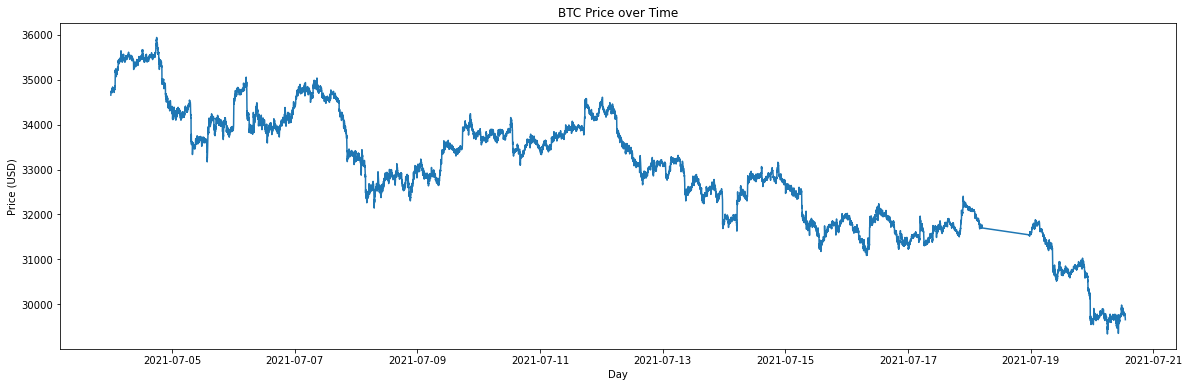

In [5]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Create the figure
fig = plt.figure(figsize=(20,6), tight_layout=False)

# Adjust the title and labels
plt.title('BTC Price over Time')
plt.xlabel('Day')
plt.ylabel('Price (USD)')

# Select all days after July 3rd
dfbtc = dfbtc.where(F.split(col('timestamp'), " ")[0] > '2021-07-03')

# Plot the dataframe (Price vs Time)
plt.plot(dfbtc.select('timestamp').collect(), dfbtc.select("newprice").collect())

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Get the open and close price of each day
df = dfbtc.withColumn("TIME", when(dfbtc['timestamp'].like('%00:00:00%'), 'OPEN').when(dfbtc['timestamp'].like('%23:59:00%'), 'CLOSE').otherwise(None))

# Save only the open and close prices
df = df.where("TIME == 'OPEN' or TIME == 'CLOSE'")

# Create a partition Window of the timestamp
my_window = Window.partitionBy().orderBy("timestamp")

# Create a column and name it the previous price (Bitcoin price of the previous day)
df = df.withColumn('prev_price', F.lag(df.newprice).over(my_window))

# Create a column and name it the difference between the two days
df = df.withColumn("diff", F.when(F.isnull(df.newprice - df.prev_price), 0)
                              .otherwise(df.newprice - df.prev_price))

# Show the first 100 entries in the dataframe
df.show(100, truncate=False)

+-----------+-------------------+---------+-----+----------+----------+
|price      |timestamp          |newprice |TIME |prev_price|diff      |
+-----------+-------------------+---------+-----+----------+----------+
|34,658.1017|2021-07-04 00:00:00|34658.1  |OPEN |null      |0.0       |
|34,373.8026|2021-07-04 23:59:00|34373.8  |CLOSE|34658.1   |-284.30078|
|34,340.3029|2021-07-05 00:00:00|34340.305|OPEN |34373.8   |-33.496094|
|33,918.3000|2021-07-05 23:59:00|33918.3  |CLOSE|34340.305 |-422.0039 |
|33,918.1200|2021-07-06 00:00:00|33918.12 |OPEN |33918.3   |-0.1796875|
|34,445.7260|2021-07-06 23:59:00|34445.727|CLOSE|33918.12  |527.60547 |
|34,461.0145|2021-07-07 00:00:00|34461.016|OPEN |34445.727 |15.2890625|
|33,340.0755|2021-07-07 23:59:00|33340.074|CLOSE|34461.016 |-1120.9414|
|33,299.9295|2021-07-08 00:00:00|33299.93 |OPEN |33340.074 |-40.14453 |
|32,964.2403|2021-07-08 23:59:00|32964.242|CLOSE|33299.93  |-335.6875 |
|32,924.4080|2021-07-09 00:00:00|32924.406|OPEN |32964.242 |-39.

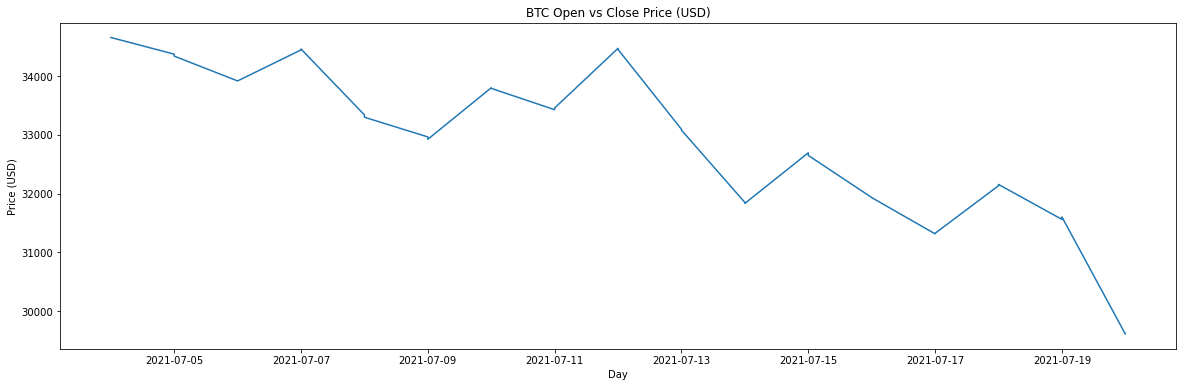

In [7]:
# Create the figure
fig = plt.figure(figsize=(20,6), tight_layout=False)

# Adjust the title and labels
plt.title('BTC Open vs Close Price (USD)')
plt.xlabel('Day')
plt.ylabel('Price (USD)')

# Plot the dataframe (Price vs Time)
plt.plot(df.select('timestamp').collect(),  df.select('newprice').collect())

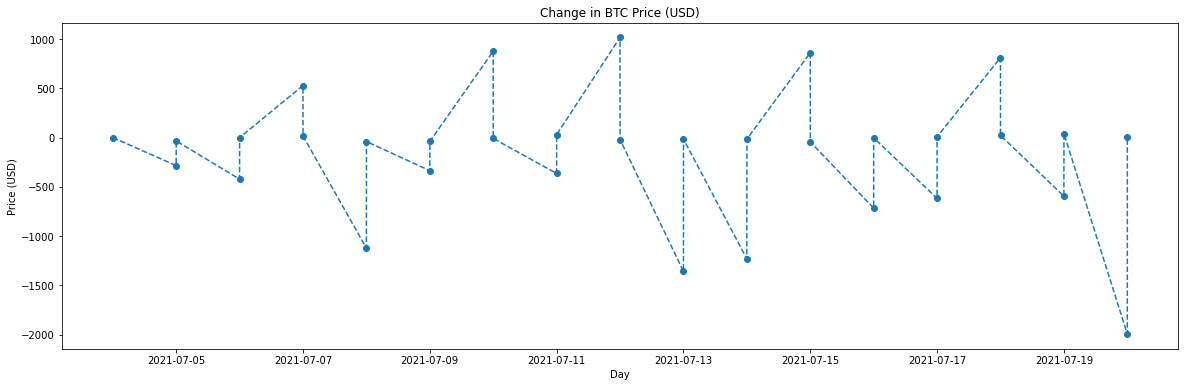

In [8]:
# Create the figure
fig = plt.figure(figsize=(20,6), tight_layout=False)

# Adjust the title and labels
plt.title('Change in BTC Price (USD)')
plt.xlabel('Day')
plt.ylabel('Price (USD)')

# Plot the dataframe (Time vs Difference in Price Per Day)
plt.plot(df.select('timestamp').collect(),  df.select('diff').collect(), marker='o', linestyle='--')

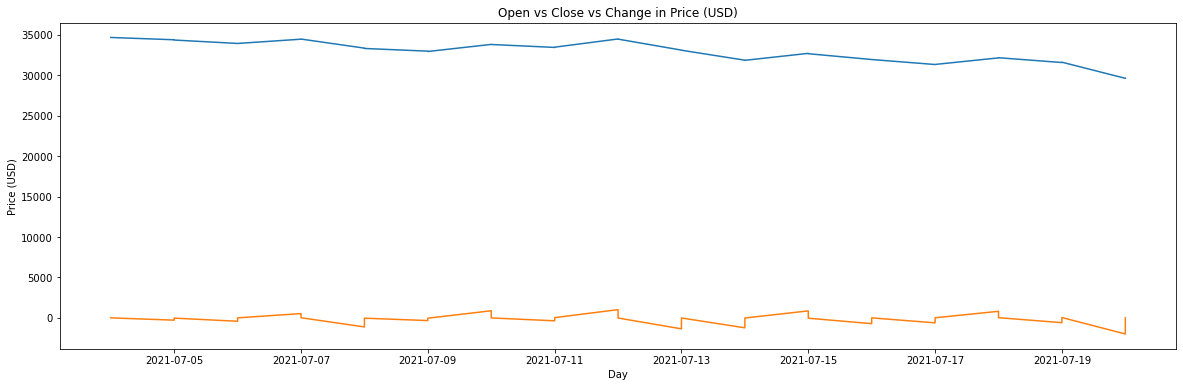

In [9]:
# Create the figure
fig = plt.figure(figsize=(20,6), tight_layout=False)

# Adjust the title and labels
plt.title('Open vs Close vs Change in Price (USD)')
plt.xlabel('Day')
plt.ylabel('Price (USD)')

# Plot the dataframe (Price vs Time)
plt.plot(df.select('timestamp').collect(),  df.select('newprice').collect())

# On the same plot, plot the Time vs Difference in Price Per Day
plt.plot(df.select('timestamp').collect(),  df.select('diff').collect())

In [10]:
# Read in the tweets json file
dft = spark.read.json("tweets.json")

In [11]:
##########################################################
#                                                        #
#             TAKES TOO LONG TO RUN                      #
#                                                        #
##########################################################


# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import StringType
# from pyspark.sql.functions import to_date
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# This snippet of code was taken from GeeksforGeeks
# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

            # def sentiment_scores(col):
            #   sid_obj = SentimentIntensityAnalyzer()
            
            #     # polarity_scores method of SentimentIntensityAnalyzer
            #     # object gives a sentiment dictionary.
            #     # which contains pos, neg, neu, and compound scores.
            #   sentiment_dict = sid_obj.polarity_scores(col)
                
            
            #   # decide sentiment as positive, negative and neutral
            #   if sentiment_dict['compound'] >= 0.05 :
            #       return "Positive"

            #   elif sentiment_dict['compound'] <= - 0.05 :
            #       return "Negative"

            #   else :
            #       return "Mutual"

# Create a user defined function to obtain the polairty of the tweet content
# udf_sentiment = udf(lambda x:sentiment_scores(x), StringType())

# Replace the emotion column with the new polarity score based on our UDF above
# dft = dft.withColumn('emotion', udf_sentiment(col("content")).alias('emotion'))

# Show the dataframe
# dft.show()

In [12]:
#from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.sql.functions import to_date, udf
# Dictionary to Convert in O(1) time
date = {
    "Jan": '01',
    "Feb": '02',
    "Mar": '03',
    "Apr": '04',
    "May": '05',
    "Jun": '06',
    "Jul": '07',
    "Aug": '08',
    "Sep": '09',
    "Oct": '10',
    "Nov": '11',
    "Dec": '12'
}

# UDF to Convert our Timestamp to a Usable Timestamp
def convert_timestamp(col):
  content = col.split(' ')
  month = date[content[1]]
  day = content[2]
  time = content[3]
  if int(month) > 7:
    return f"2020-{month}-{day} {time[:-2]}00"
  else:
    return f"2021-{month}-{day} {time[:-2]}00"


# Create user defined function to convert the time to a usable timestamp
udf_fun = udf(lambda x:convert_timestamp(x), StringType())

# Replace the timestamp column with the new timestamp using our UDF above
dft = dft.withColumn('timestamp', udf_fun(col("timestamp")).cast('timestamp'))

# Show the dataframe
dft.show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------------------------------------------------------------------------------------------+----------+-----------+-------------------+-------------------+------------------------------------------------------------------+-------------------+-------------------------------------+
|content                                                                                                                                                                                                                                                                                                 |emotion |hashtags                                                                                       |like_

In [13]:
# Show the type of the content in our columns
dft.dtypes

[('content', 'string'),
 ('emotion', 'string'),
 ('hashtags', 'array<string>'),
 ('like_count', 'bigint'),
 ('reply_count', 'bigint'),
 ('timestamp', 'timestamp'),
 ('tweet_id', 'bigint'),
 ('tweet_url', 'string'),
 ('user_id', 'bigint'),
 ('username', 'string')]

In [14]:
# Remove the duplicates from our data
dft = dft.select('*').dropDuplicates()


In [15]:
# Obtain the total number of tweets for each individual emotion
dft.groupBy('emotion').count().show()

+--------+------+
| emotion| count|
+--------+------+
|  Mutual| 56889|
|Positive|214503|
|Negative|153971|
+--------+------+



In [16]:
from pyspark.sql.functions import split

# Create a column and label it as 'date' which contains the below sample entry
# Example: 2021-07-03
# This will be used for plotting data based on the individual day rather than
# having to deal with individual timestamps
dft_converted_to_date = dft.persist().withColumn("date", (when(dft['timestamp'].like('% %'), split(col("timestamp")," ")[0]).alias('month')))

In [17]:
# Get all days after July 3rd
dft_converted_to_date = dft_converted_to_date.where(col('date') > "2021-07-03")

In [18]:
# Get the total number of each emotion per day
emotions = dft_converted_to_date.persist().groupBy('date', 'emotion').count()

# Convert the rows into columns based on the date
# Example:

# Date        Emotion   Count
# 2021-02-21  Positive  400

# Converts to:

# Date        Positive      Mutual      Negative
# 2021-02-21  400           200         100

converted_emotion = emotions.persist().groupBy('date')\
  .pivot('emotion')\
  .max('count')\
  .fillna(0)

# Show the updated dataframe
converted_emotion.show()

+----------+------+--------+--------+
|      date|Mutual|Negative|Positive|
+----------+------+--------+--------+
|2021-07-18|   970|    2661|    4267|
|2021-07-07|  3124|    8520|   12871|
|2021-07-12|  2806|    8214|   12275|
|2021-07-28|     0|       0|       1|
|2021-07-13|  2727|    7756|   11336|
|2021-07-16|  3107|    8291|   11239|
|2021-07-20|  2105|    6281|    8702|
|2021-07-11|  2850|    7827|   11722|
|2021-07-26|     0|       0|       4|
|2021-07-08|  3159|    9327|   11665|
|2021-07-15|  2830|    8517|   11337|
|2021-07-27|     0|       4|       1|
|2021-07-22|     0|       2|       0|
|2021-07-06|  3018|    8504|   11092|
|2021-07-10|  2682|    7825|   10804|
|2021-07-04|  3559|    7623|   11016|
|2021-07-25|     0|       1|       0|
|2021-07-05|  3075|    7943|   11054|
|2021-07-19|  2438|    7283|   10486|
|2021-07-09|  3053|    8726|   11571|
+----------+------+--------+--------+
only showing top 20 rows



[Text(0, 0, '2021-07-18'),
 Text(1, 0, '2021-07-07'),
 Text(2, 0, '2021-07-12'),
 Text(3, 0, '2021-07-28'),
 Text(4, 0, '2021-07-13'),
 Text(5, 0, '2021-07-16'),
 Text(6, 0, '2021-07-20'),
 Text(7, 0, '2021-07-11'),
 Text(8, 0, '2021-07-26'),
 Text(9, 0, '2021-07-08'),
 Text(10, 0, '2021-07-15'),
 Text(11, 0, '2021-07-27'),
 Text(12, 0, '2021-07-22'),
 Text(13, 0, '2021-07-06'),
 Text(14, 0, '2021-07-10'),
 Text(15, 0, '2021-07-04'),
 Text(16, 0, '2021-07-25'),
 Text(17, 0, '2021-07-05'),
 Text(18, 0, '2021-07-19'),
 Text(19, 0, '2021-07-09'),
 Text(20, 0, '2021-07-14'),
 Text(21, 0, '2021-07-17')]

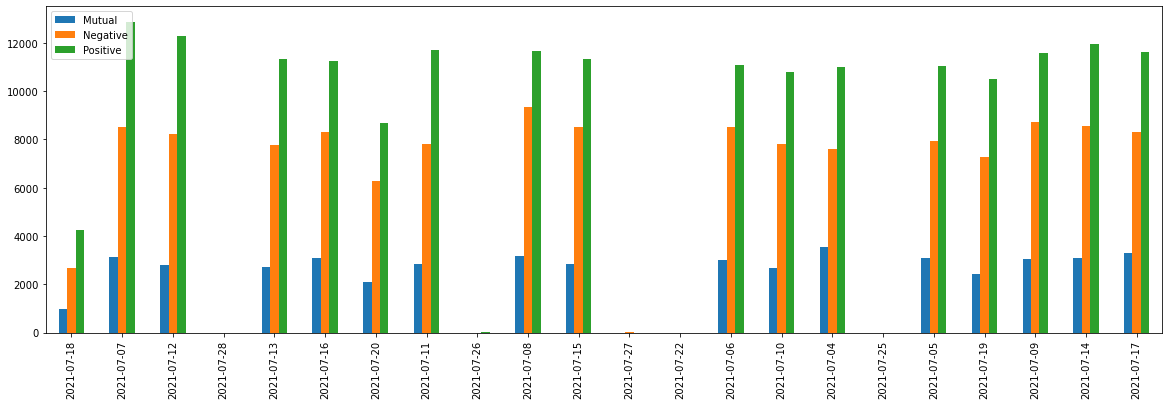

In [19]:
# Convert the date column name to 'index'
converted_emotion = converted_emotion.withColumnRenamed('date', 'index')

# Convert the index column entries to a list to use for plotting
xlabels = converted_emotion.select('index').rdd.flatMap(list).collect()

# Convert the dataframe to pandas to plot a bar graph and set the xlabels
converted_emotion.toPandas().plot.bar(figsize=(20,6)).set_xticklabels(xlabels)

[Text(0, 0, '2021-07-05')]

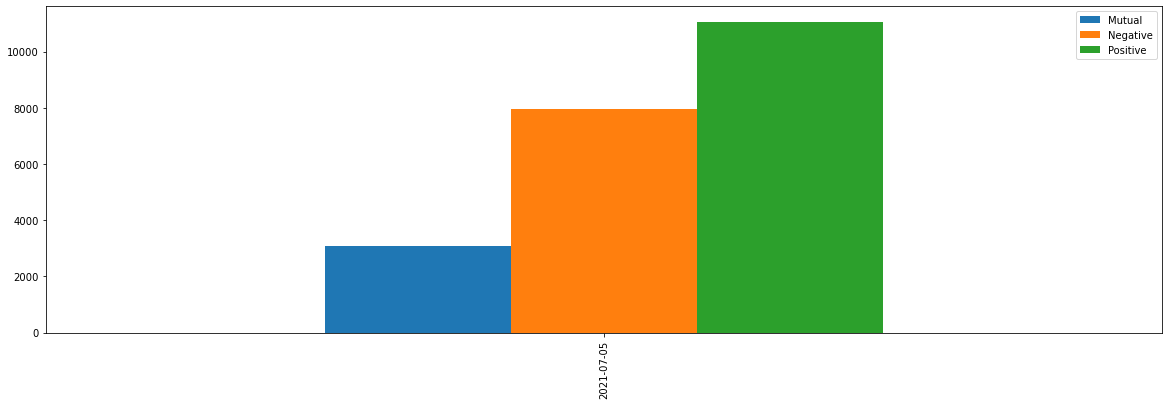

In [20]:
# 2021-07-05 HAD BIGGEST DECREASE IN PRICE

# Get the data for the given day (2021-07-05)
biggest_decrease = converted_emotion.where(col('index') == '2021-07-05')

# Convert the index column entries to a list to use for plotting
xlabels = biggest_decrease.select('index').rdd.flatMap(list).collect()

# Convert the dataframe to pandas to plot a bar graph and set the xlabels
biggest_decrease.toPandas().plot.bar(figsize=(20,6)).set_xticklabels(xlabels)

In [21]:
# 2021-07-05 HAD BIGGEST DECREASE IN PRICE

# Get all the tweets for the given day (2021-07-05)
biggest_decrease_tweets = dft_converted_to_date.where(col('date') == '2021-07-05').where(col('content').contains('btc'))

# Display the tweets with the highest like count
biggest_decrease_tweets.orderBy('like_count', ascending=False).show(truncate=True)

+--------------------+--------+--------------------+----------+-----------+-------------------+-------------------+--------------------+-------------------+--------------------+----------+
|             content| emotion|            hashtags|like_count|reply_count|          timestamp|           tweet_id|           tweet_url|            user_id|            username|      date|
+--------------------+--------+--------------------+----------+-----------+-------------------+-------------------+--------------------+-------------------+--------------------+----------+
|@elonmusk pump bt...|Positive|                  []|      7468|        303|2021-07-05 07:15:00|1411946838102577152|https://www.twitt...|          143799946|Crypt0Men العملات...|2021-07-05|
|$COOKIE is Commun...|Positive|[#crypto, #btc, #...|      1104|        159|2021-07-05 19:10:00|1412126809324392450|https://www.twitt...|1408735956858028034|$COOKIE COIN (Off...|2021-07-05|
|Imo, by the next ...|Negative|                  []|   

[Text(0, 0, '2021-07-11')]

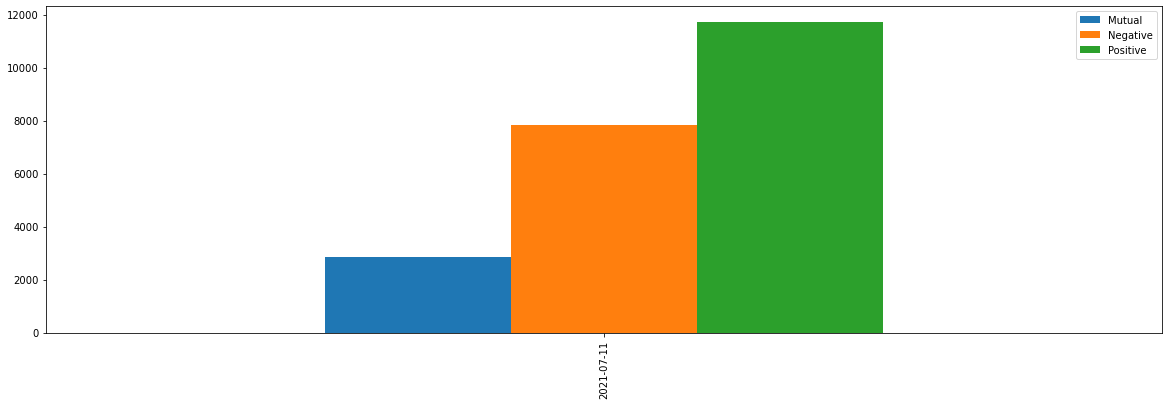

In [27]:
# 2021-07-11 HAD BIGGEST INCREASE IN PRICE

# Get the data for the given day (2021-07-09)
biggest_increase = converted_emotion.where(col('date') == '2021-07-11')

# Convert the index column entries to a list to use for plotting
xlabels = biggest_increase.select('index').rdd.flatMap(list).collect()

# Convert the dataframe to pandas to plot a bar graph and set the xlabels
biggest_increase.toPandas().plot.bar(figsize=(20,6)).set_xticklabels(xlabels)

In [28]:
# 2021-07-11 HAD BIGGEST INCREASE IN PRICE

# Get all the tweets for the given day (2021-07-11)
increase = dft_converted_to_date
biggest_increase_tweets = increase.where(col('date') == '2021-07-11')

# Display the tweets with the highest like count
biggest_increase_tweets.orderBy('like_count', ascending=True).show()

+-------------------------------------+--------+--------------------+----------+-----------+-------------------+-------------------+--------------------+-------------------+--------------------+----------+
|                              content| emotion|            hashtags|like_count|reply_count|          timestamp|           tweet_id|           tweet_url|            user_id|            username|      date|
+-------------------------------------+--------+--------------------+----------+-----------+-------------------+-------------------+--------------------+-------------------+--------------------+----------+
|                 Kind of like when...|Positive|                  []|         0|          0|2021-07-11 00:18:00|1414016329129070595|https://www.twitt...|         3240999631|       Peter Johnson|2021-07-11|
|                 Sydney Braced for...|  Mutual|                  []|         0|          0|2021-07-11 00:25:00|1414017908821303299|https://www.twitt...|           15977038|Cry

In [29]:
# Get all the distinct Twitter users and how many tweets they had
dtinct = dft_converted_to_date.groupBy('username').count()

# Display the distinct Twitter users based on highest amount of tweets
dtinct.orderBy('count', ascending=False).show()

+--------------------------------+-----+
|                        username|count|
+--------------------------------+-----+
|              BTC Market Alert🚨| 1922|
|            Crypto Trader Pro...| 1792|
|               BTC情報アラート📊| 1575|
|              DYOR.net Dev & Bot| 1496|
|                   Volume Alerts| 1451|
|仮想通貨騰落通知bot君（BTC建て）| 1196|
|                       poppo_bot| 1166|
|                    Crypto Blitz| 1076|
|                    Prime Trader| 1061|
|                    Whale Sniper|  954|
|                    BitcoinAgile|  935|
|                    ₿TC ₿lock₿ot|  877|
|                          マルコ|  856|
|                      Aspen Labs|  786|
|                Bitcoin Confirms|  783|
|                   The future...|  775|
|    仮想通貨価格通知BOT(BTC/J...|  748|
|                      BTC EM DIA|  728|
|                 Bitcoin価格速報|  727|
|                 Bitcoin updates|  672|
+--------------------------------+-----+
only showing top 20 rows



In [30]:
# Obtain the amount of positive and negative tweets by each user about BTC
avg_emotion = dft_converted_to_date.groupBy('user_id','emotion').count()

In [31]:
# Convert the rows into columns based on the date
# Example:

# Date        Emotion   Count
# 1111144444  Positive  400

# Converts to:

# Date        Positive      Mutual      Negative
# 1111144444  400           200         100
avg_emotion = avg_emotion.groupBy('user_id')\
  .pivot('emotion')\
  .max('count')\
  .fillna(0)

avg_emotion.show()

+-------------------+------+--------+--------+
|            user_id|Mutual|Negative|Positive|
+-------------------+------+--------+--------+
|1395619031093170177|     0|       0|       1|
|1356800140535808001|     2|       1|       1|
|1301951551620161537|     1|       0|       0|
|1374857715072241668|     0|       0|       1|
|           90917895|     0|       0|       3|
|1346620618846973954|     1|       0|       2|
|1175467856949067777|     1|       3|       7|
| 941287889916321792|     0|       1|       1|
|1374396919011700736|     0|       0|       2|
|1016317435060858880|     1|       0|       1|
|1037251590820950017|     0|       0|       6|
|1266244227966500871|     0|       0|       3|
|1335866723325493251|     0|       1|       1|
|1006256106346287105|     0|       0|       1|
|          174548385|     2|       2|       1|
|1367297168407547906|     1|       2|       2|
| 966943657688317952|     1|       3|       1|
|1413087903660584963|     0|       0|       1|
| 92780037431